In [12]:
import os

import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number
import pickle
from tqdm import tqdm
import torch
from torch.utils.data import Sampler, DataLoader
from utils import Logger, load_pretrain, gpu

from CarlaDataset import from_numpy, worker_init_fn
from Net import get_model
from sklearn.model_selection import train_test_split


# root_path = os.path.dirname(os.path.abspath(__file__))
from pathlib import Path
# Get the current notebook file path
notebook_file_path = Path(os.path.abspath(""))
# Get the parent directory
root_path = notebook_file_path.parent
sys.path.insert(0, root_path)

torch.cuda.set_device(1)


config = dict()
config["epoch"] = 10
config["batch_size"] = 32
config["save_dir"] = "./weight_and_log_all"
config["save_freq"] = 1
config["num_epochs"] = 36
config["display_freq"] = 10
config["test_freq"] = 1


In [17]:
Dataset, collate_fn, net, loss, post_process, opt = get_model()

ckpt_num = 40
# load pretrain model
ckpt_path = f'net{ckpt_num}.000.ckpt'
if not os.path.isabs(ckpt_path):
    ckpt_path = os.path.join(config["save_dir"], ckpt_path)
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
load_pretrain(net, ckpt["state_dict"])
net.eval()

# Data loader for evaluation
with open('test_data.pkl', 'rb') as test_file:
    test_data = pickle.load(test_file)

test_loader = DataLoader(
    test_data,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [25]:
for ii, data in tqdm(enumerate(test_loader)):
    data = dict(data)
    with torch.no_grad():
        output = net(data)
    break

0it [00:00, ?it/s]


In [26]:
data.keys()

dict_keys(['feat', 'ctrs', 'nbr_waypoints', 'label'])

In [41]:
data['feat']

[tensor([[[103.1654,  18.8472,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1654,  18.8471,   1.0000],
          [103.1655,  18.8413,   1.0000],
          [103.1657,  18.8156,   1.0000],
          [103.1663,  18.7636,   1.0000]]])]

In [42]:
data['ctrs']

[tensor([[103.1663,  18.7636]], grad_fn=<PinMemoryBackward0>)]

In [43]:
data['nbr_waypoints']

[tensor([[ 94.2966,  -6.6421],
         [ 92.3792,  -5.4168],
         [ 93.0717,  -5.7375],
         ...,
         [ 99.2247,  47.9534],
         [102.7148,  48.2163],
         [106.2049,  48.4792]], dtype=torch.float64)]

In [27]:
del data['label']
with torch.no_grad():
    output = net(data)

In [34]:
output['reg'][0][0].shape

torch.Size([6, 30, 2])

In [194]:
idx = 31    # batch 0

torch.Size([20, 3])
torch.Size([30, 3])
torch.Size([6, 30, 2])


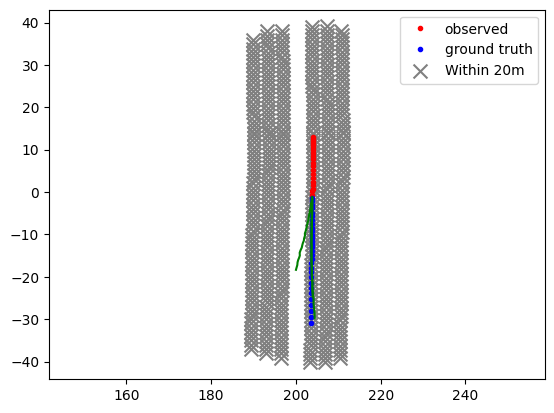

In [195]:
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree


print(data['feat'][idx][0].shape)
print(data['label'][idx].shape)
print(output['reg'][idx][0].shape)


obs_traj = data['feat'][idx][0].cpu().numpy()
plt.plot(obs_traj[:, 0], obs_traj[:, 1], '.',c='r', label='observed')
fut_traj = data['label'][idx].cpu().numpy()
plt.plot(fut_traj[:, 0], fut_traj[:, 1], '.',c='b', label='ground truth')
for j in range(3):
    traj = output['reg'][idx][0][j].cpu().numpy()
    plt.plot(traj[:, 0], traj[:, 1], 'g')

# for i in range(1, len(data['feat'][idx])):
#     others = data['feat'][idx][i].cpu().numpy()
#     plt.plot(others[:, 0], others[:, 1], '.',c='pink', label='others')

waypoints_xy = pickle.load(open('waypoints_xy.pkl', 'rb'))
waypoints_xy = np.array(waypoints_xy)
tree = cKDTree(waypoints_xy)

radius = 40.0
target_coordinate = data['feat'][idx][0][-1][:2].numpy().tolist()
indices = tree.query_ball_point(target_coordinate, radius)
filtered_coords = waypoints_xy[indices]
plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], color='grey', label='Within 20m', marker='x', s=100)



plt.axis('equal')
plt.legend()
# plt.savefig(f'./fig/result{ckpt_num}.png')

/tmp/ipykernel_3000164/3072852002.py:93: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  traj_ends[i].set_data(traj[-1, 0], traj[-1, 1])
MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_3000164/3072852002.py:93: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  traj_ends[i].set_data(traj[-1, 0], traj[-1, 1])
/tmp/ipykernel_3000164/3072852002.py:87: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  traj_pred_ends[i].set_data(traj[count-22, 0], traj[count-22, 1])


IndexError: index 30 is out of bounds for axis 0 with size 30

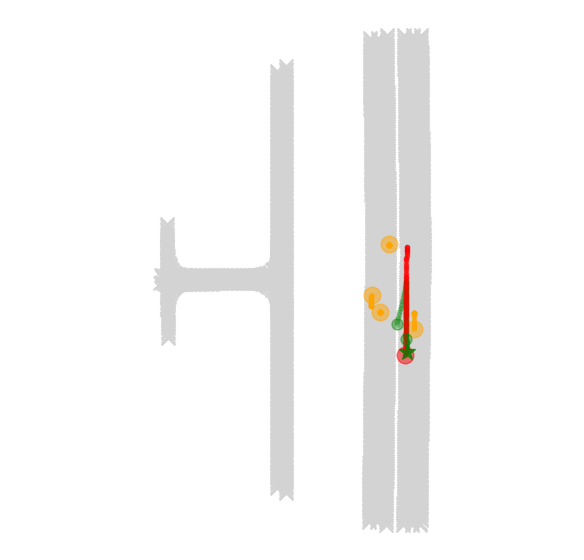

In [196]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0.03, 0.05, 0.94, 0.9])



waypoints_xy = pickle.load(open('waypoints_xy.pkl', 'rb'))
waypoints_xy = np.array(waypoints_xy)
tree = cKDTree(waypoints_xy)

radius = 100
target_coordinate = data['feat'][idx][0][-1][:2].numpy().tolist()
indices = tree.query_ball_point(target_coordinate, radius)
filtered_coords = waypoints_xy[indices]
plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], color='lightgrey', label='Within 20m', marker='x', s=100)




ax.axis('equal')
plt.axis('off')

trajs_plot = []
traj_lines = []
traj_ends = []

# obs_traj_all = data['feat'][idx].detach().cpu().numpy()
# obs_traj_all = data['feat'][idx].detach().cpu().numpy()

# Append reshaped label to the first element
obs_traj_all = [None] * len(data['feat'][idx])
obs_traj_all[0] = np.append(data['feat'][idx][0].detach().cpu().numpy(), data['label'][idx].detach().cpu().numpy(), axis=0)

# Replicate the last coordinate 30 times for each trajectory
for i in range(1, len(obs_traj_all)):
    obs_traj_all[i] = data['feat'][idx][i].detach().cpu().numpy()

traj_pred = output['reg'][idx][0].detach().cpu().numpy()

for i, traj in enumerate(obs_traj_all):
    zorder = 10
    if i == 0:
            clr = 'r'
            zorder = 20
    else:
            clr = 'orange'
    trajs_plot.append({'traj':traj, 'color':clr, 'zorder':zorder})
    
    traj_line, = ax.plot([],[], marker='.', alpha=0.5, color=clr, zorder=zorder)
    traj_end, = ax.plot([], [], alpha=0.5, color=clr, marker='o', zorder=zorder, markersize=12)
    traj_lines.append(traj_line)
    traj_ends.append(traj_end)

traj_pred_lines = []
traj_pred_ends = []
for i in range(len(traj_pred[0])):
    # traj = np.matmul((traj_pred[0][i] - orig.numpy()), rot.T)
    if i==0:
        alpha=0.5
        clr = 'g'
    else:
        alpha=0.15
        # clr = 'b'

    traj = traj_pred[0][i]
    traj_pred_line, = ax.plot([], [], alpha=alpha, color=clr, linewidth=3, marker='.', zorder=15)


    if i == 0:
        traj_pred_end, = ax.plot([], [], alpha=alpha+0.25, marker='*', color=clr, markersize=12, zorder=30)
    else:
        traj_pred_end, = ax.plot([], [], alpha=alpha+0.25, marker='o', color=clr, markersize=8, zorder=30)

    traj_pred_lines.append(traj_pred_line)
    traj_pred_ends.append(traj_pred_end)

count = 0
def update_plot(frame):
    global count
    count += 1

    if count > 21:
        for i in range(3):
            traj = traj_pred[i]
            traj_pred_lines[i].set_data(traj[:count-21, 0], traj[:count-21, 1])
            traj_pred_ends[i].set_data(traj[count-22, 0], traj[count-22, 1])

    for i, traj_line in enumerate(traj_lines):
        traj = trajs_plot[i]['traj'][:count]
        if len(traj) != 0:
            traj_line.set_data(traj[:, 0], traj[:, 1])
            traj_ends[i].set_data(traj[-1, 0], traj[-1, 1])

    return traj_lines + traj_ends + traj_pred_lines + traj_pred_ends

ani = animation.FuncAnimation(fig, update_plot, frames=50, interval=200, blit=True, repeat=False)
ani.save('./fig/animation'+str(idx)+'.gif', writer='imagemagick', fps=5)  # Specify the frames per second (fps)

# ani.save('./fig/animation'+str(idx)+'.gif', writer='imagemagick')

In [ ]:
aa

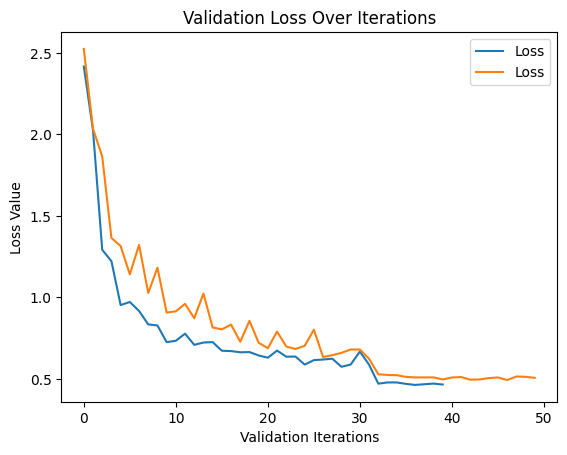

In [ ]:
import matplotlib.pyplot as plt

def read_loss_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    loss_values = []

    for line in lines:
        if line.startswith('loss'):
            tokens = line.split()
            # 损失值在第二个位置
            loss = float(tokens[1])
            loss_values.append(loss)

    return loss_values

def plot_loss(loss_values):
    plt.plot(loss_values, label='Loss')
    plt.xlabel('Validation Iterations')
    plt.ylabel('Loss Value')
    plt.title('Validation Loss Over Iterations')
    plt.legend()
    # plt.show()


file_path = '/data/fyy/Carla_prediction/weight_and_log_all/log'
loss_values = read_loss_from_file(file_path)
plot_loss(loss_values)

file_path = '/data/fyy/Carla_prediction/weight_and_log/log'
loss_values = read_loss_from_file(file_path)
plot_loss(loss_values)


# plt.savefig(f'./fig/loss.png')

In [ ]:
# import os
# import imageio

# def create_gif(image_folder, gif_name, start_index, end_index):
#     images = []
#     for i in range(start_index, end_index + 1):
#         filename = f'result{i}.png'
#         file_path = os.path.join(image_folder, filename)
#         images.append(imageio.imread(file_path))
#     imageio.mimsave(gif_name, images, duration=0.1)  # 设置每帧的持续时间（秒）

# # 指定图片文件夹和生成的 GIF 文件名
# image_folder = '/data/fyy/Carla_prediction/fig'
# gif_name = '/data/fyy/Carla_prediction/fig/result_animation.gif'

# # 设置起始和结束的索引
# start_index = 1
# end_index = 18

# # 调用函数生成 GIF
# create_gif(image_folder, gif_name, start_index, end_index)


/tmp/ipykernel_2800485/644636104.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
